In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as sts
import scipy
import math
import itertools
from scipy.special import zeta, kolmogorov
from math import pi, sin, cos, sqrt, exp, log
from mpl_toolkits.mplot3d import Axes3D
import sympy as sym
import seaborn as sns
from itertools import chain, combinations
from sklearn.model_selection import train_test_split as tr
import scipy.optimize as opt

In [ ]:
df = pd.read_table('/content/IB_statistics_data_HW2.3.txt',sep='\s+', engine='python')

In [ ]:
df

,Ex1y,Ex1x1,Ex1x2,Ex3y,Ex3x1,Ex3x2,Ex3x3,Ex3x4,Ex3x5,Ex3x6,Ex5y,Ex5x1,Ex5x2,Ex5x3,Ex5x4,Ex5x5,Ex5x6,Ex5x7,Ex5x8,Ex5x9,Ex5x10
0,10.218252,1.302442,-1.320244,2.875406,-1.090962,-0.136285,-0.860347,0.851991,0.884934,0.877527,-2.949731,-2.427045,-0.302324,2.616774,0.482374,1.070041,-2.768137,-2.121441,-3.360535,-0.415121,-1.599841
1,8.149332,2.117985,-2.310214,8.613595,-1.594294,-0.819950,-0.344157,0.334646,0.379764,0.379576,-1.729974,-0.885513,-2.508394,2.326015,1.864762,0.291996,-2.838964,-1.983057,-2.057130,0.204266,-1.667311
2,-13.516448,-2.312135,2.538834,-12.537362,-3.392841,-3.932119,-2.560890,2.584925,2.578855,2.753641,-0.390737,-1.762951,-2.366408,4.725037,2.789992,2.861771,-5.277129,-4.685437,-5.923246,-0.018065,-1.810166
3,8.923820,1.990612,-2.105968,21.745406,0.024919,0.756021,1.770734,-1.782050,-1.706574,-1.721968,-8.019596,-4.770047,1.123429,4.880111,-0.890576,-5.131511,-3.641705,-5.964670,-4.190813,-0.622141,-0.814848
4,6.953239,1.747740,-1.869673,41.556636,2.411488,1.009445,3.809386,-3.822074,-3.758777,-3.785552,-1.683830,1.807668,-5.534132,4.137198,5.604898,-9.081822,-3.582780,-2.686579,-5.500250,1.498781,-0.013275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,-4.681744,0.108523,-0.056534,6.408370,-2.498930,-0.841144,-0.771334,0.733905,0.807060,0.814956,0.583870,0.850460,-4.540463,4.189735,5.178928,-6.845812,-2.962178,-5.803322,-4.850356,0.946155,-0.279203
70,3.524741,0.779568,-0.758771,9.075647,-2.036530,-0.967633,-0.346243,0.339394,0.413119,0.439489,-2.239776,-1.158613,-2.474816,3.960013,2.347506,1.194667,-5.392972,-1.777471,-3.769837,-0.106846,-2.691767
71,10.298628,1.458550,-1.529964,54.759798,4.108141,1.678646,5.787821,-5.788593,-5.749110,-5.855381,-4.802104,-3.429757,-0.954022,5.497153,0.397768,1.445531,-5.344610,-6.747451,-1.917066,-0.211350,-1.749394
72,17.962820,2.854779,-3.183744,40.808679,2.189098,1.232231,3.892793,-3.952729,-3.888908,-3.884452,-3.878996,-2.499318,-1.330903,3.447307,1.209729,1.606427,-4.335669,-3.262283,-3.446784,-0.090815,-1.515972


In [ ]:
alpha = 0.05

## Задача 1.

- (a). Проверим, что ошибки имеют нормальное распределение, для этого воспользуемся критерием Шапиро-Уилка.

In [ ]:
y = df['Ex1y'].to_numpy()
X = df.loc[:, 'Ex1x1':'Ex1x2'].to_numpy()
n = len(y)
m = len(X.T)

In [ ]:
K = X.T @ X
beta = np.linalg.inv(K) @ X.T @ y

In [ ]:
statistic, p = sts.shapiro(y - X @ beta)
if p < alpha:
    print(f'Есть основания отклонить H_0 в пользу H_1 с уровнем значимости {alpha}')
else:
    print(f'Нет оснований отклонить H_0 в пользу Н_1  с уровнем значимости {alpha}')

Нет оснований отклонить H_0 в пользу Н_1  с уровнем значимости 0.05


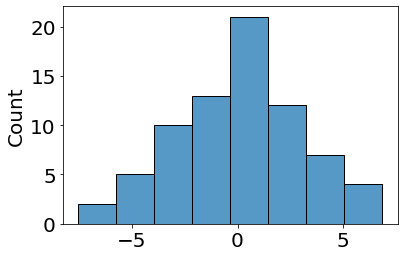

In [ ]:
sns.histplot(y - X @ beta)

С уровнем значимости 0.05 нет оснований отклонить гипотезу о нормальности ошибок.

- (b). Убедимся, что модель является мультиколлинеарной

In [ ]:
def cond(K):
    eigvalues, eigvectors = np.linalg.eig(K)
    condK = np.max(eigvalues) / np.min(eigvalues)
    print(f'Число обусловленности cond(X^T * X) =', condK)
    
def r_mes(K):
    l = len(K)
    r = 0
    for i in range(l):
        for j in range(l - 1):
            if j != i:
                w = abs(K[i][j]) / sqrt(K[i][i] * K[j][j])
                if w > r:
                    r = w
    print('Максимальная парная сопряженность w(X^T * X) = ', r)

In [ ]:
cond(K)
r_mes(K)

Число обусловленности cond(X^T * X) = 3455.92881171816
Максимальная парная сопряженность w(X^T * X) =  0.9994178519289634


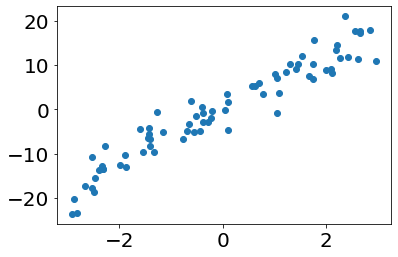

In [ ]:
plt.scatter(X.T[0], y)

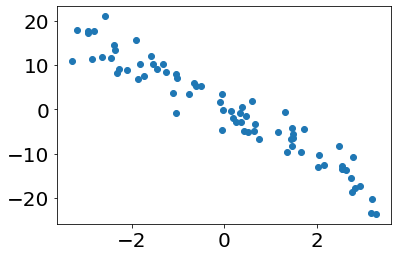

In [ ]:
plt.scatter(X.T[1], y)

Как видно модель действительно является мультиколлинеарной.

- (с). Построим доверительный эллипсоид

In [ ]:
F = sts.f.ppf(q = alpha, dfn = m, dfd = n - m, loc=0, scale=1)
s = np.var(y)

In [ ]:
xs, ys = sym.symbols('x, y')
Ks = sym.Matrix(K)
betas = sym.Matrix(beta)
Xs = sym.Matrix([xs, ys])
ellipsodes = ((betas - Xs)).T * Ks * (betas - Xs)
ellipsodes

Matrix([[(-x - 6.63940208583495)*(-229.617687594581*x + 248.29595593325*y + 1354.45848566357) + (-y - 11.5949638760834)*(248.29595593325*x - 268.806488697034*y - 1468.26483837133)]])

In [ ]:
ellipse = sym.simplify((3.14169788177628 - ys) * (228.770088987317 * xs - 247.394574504342 * ys  - 1284.44406333984)
             + (9.01203073858739 - xs) * (-211.76932913334 * xs + 228.770088987317 * ys + 1189.74519965446) 
             - (m / (n - m)) * F * s)
ellipse

211.76932913334*x**2 - 457.540177974634*x*y - 2379.49039930893*x + 247.394574504342*y**2 + 2568.88812667968*y + 6686.51782343431

По полученному уравнению построим кривую https://www.desmos.com/calculator/k2jcqk6nml

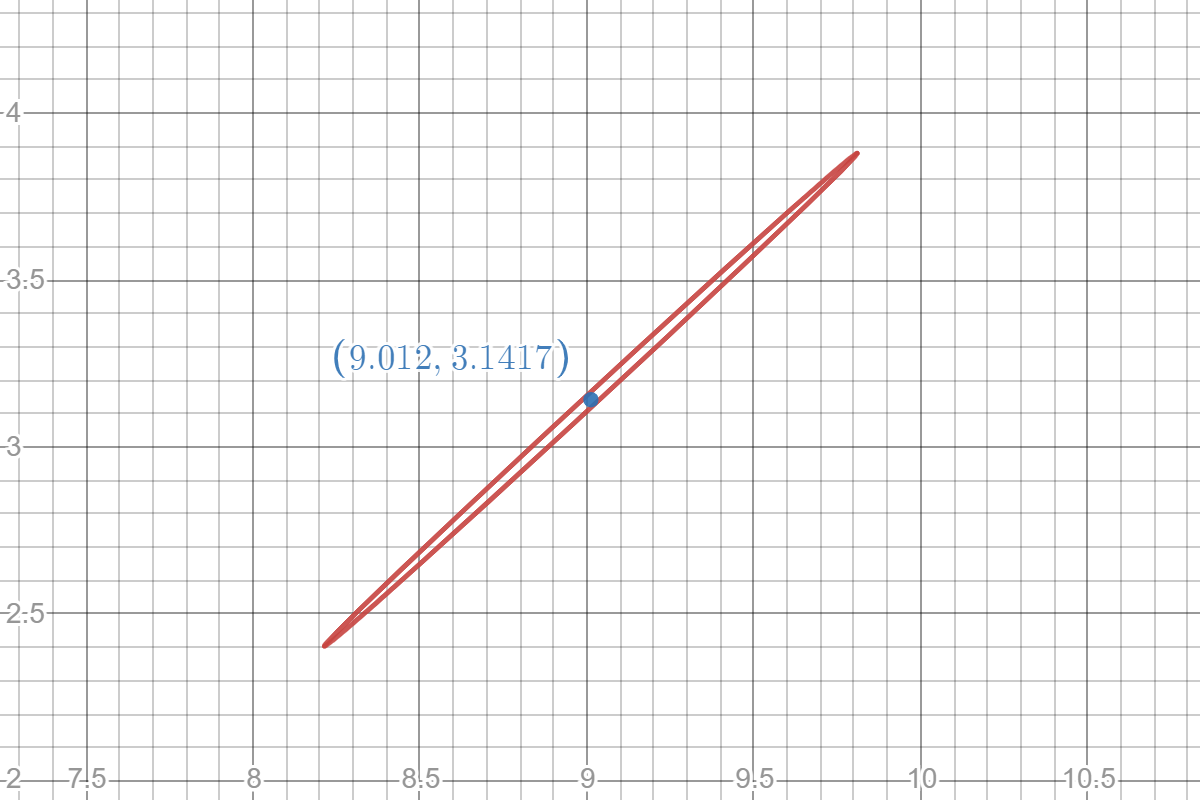

## Задача 2.

- (a) Докажем, что норма ридж-оценки $||\tilde\beta(r)||$ является убывающей функцией по $r$.

    По определению из лекции $||\tilde\beta(r)|| = ||(\mathbb{X}^T\mathbb{X} + r\mathbb{I})^{-1}\mathbb{X}^T\mathbb{Y}||$

    Рассмотрим $||\tilde\beta(r)||^2 = ||(\mathbb{X}^T\mathbb{X} + r\mathbb{I})^{-1}\mathbb{X}^T\mathbb{Y}||^2  = \|\tilde\beta\|^2 = \mathbb{Y}^T\mathbb{X}(\mathbb{X}^T\mathbb{X} + r \mathbb{I})^{-2}\mathbb{X}^T\mathbb{Y}.$ 
    
    Пусть $\mathbb{X} = \mathbf{U}\mathbf{Σ}\mathbf{V^T}$ --  сингулярное разложение матрицы $\mathbb{X}$. 
    
    Тогда $\||\tilde\beta\||^2 = \mathbb{Y}^T \mathbf{U}\mathbf{Σ}(\mathbf{Σ}^2 + r\mathbb{I})^{-2}\mathbf{Σ}\mathbf{U}^T\mathbb{Y} = \sum_\limits{i=1}^m \frac{s_i^2}{(s_i^2 + r)^2} w_i^2, \ w= \mathbf{U}^T\mathbb{Y}$. Откуда видно, что $||\tilde\beta(r)||$ -- убывающая по $r$ функция.

- (b) Докажем, что сумма квадратов ошибок отклонений $Q(r)$ является возрастающей по $r$ функцией.

    По определению имеем $Q(r) = (\mathbb{Y} - \mathbb{X}\tilde\beta(r))^T(\mathbb{Y} - \mathbb{X}\tilde\beta(r)) = (\mathbb{Y} - \mathbb{X}(\mathbb{X}^T\mathbb{X} + r\mathbb{I})^{-1}\mathbb{X}^T\mathbb{Y})^T(\mathbb{Y} - \mathbb{X}(\mathbb{X}^T\mathbb{X} + r\mathbb{I})^{-1}\mathbb{X}^T\mathbb{Y}) = (\mathbb{I} - \mathbb{X}(\mathbb{X}^T\mathbb{X} + r\mathbb{I})^{-1}\mathbb{X}^T)^T\mathbb{Y}^T\mathbb{Y}(\mathbb{I} - \mathbb{X}(\mathbb{X}^T\mathbb{X} + r\mathbb{I})^{-1}\mathbb{X}^T) = (\mathbb{I} - \mathbb{X}(\mathbb{X}^T\mathbb{X} + r\mathbb{I})^{-1}\mathbb{X}^T)^T\sum y_i^2(\mathbb{I} - \mathbb{X}(\mathbb{X}^T\mathbb{X} + r\mathbb{I})^{-1}\mathbb{X}^T) = \sum y^2_i||(\mathbb{I} - \mathbb{X}(\mathbb{X}^T\mathbb{X} + r\mathbb{I})^{-1}\mathbb{X}^T)||^2$. Применим тот же прием, что и при доказательстве пункта (b), то есть получим сингулярное разлоежние $\mathbb{X}$. И далее получим сумму $\sum \left(1 -\frac{s_i^2}{(s_i + r)^2}\right)$, которая является возрастающей функцией по $r$. Также, поскольку $Q(r)$ -- скалярная величина, то $||Q(r)|| = Q(r)$.




## Задача 3. 

- (a). Для данной задачи построим сначала МНК оценку параметров модели.

In [ ]:
y = df['Ex3y'].to_numpy()
X = df.loc[:, 'Ex3x1':'Ex3x6'].to_numpy()
n = len(y)
m = len(X.T)

Будем строить ридж-оценку, начиная с $r = 0$, как было показано на лекции. Для этого реализуем функцию `ridge_regression`.

In [ ]:
beta = np.linalg.inv(X.T @ X) @ X.T @ y
eps = (y - X @ beta) ** 2
k = len(y) - len(X.T) - 1
sigma = sum((y - X @ beta) ** 2) / k
sigma

18.791586274116153

Сумма квадратов ошибок в случае МНК-оценки меньше, чем в случае оптимальной ридж-оценки в 0.9475686286029547 раз
График зависимости суммы квадратов ошибок отклонений от r


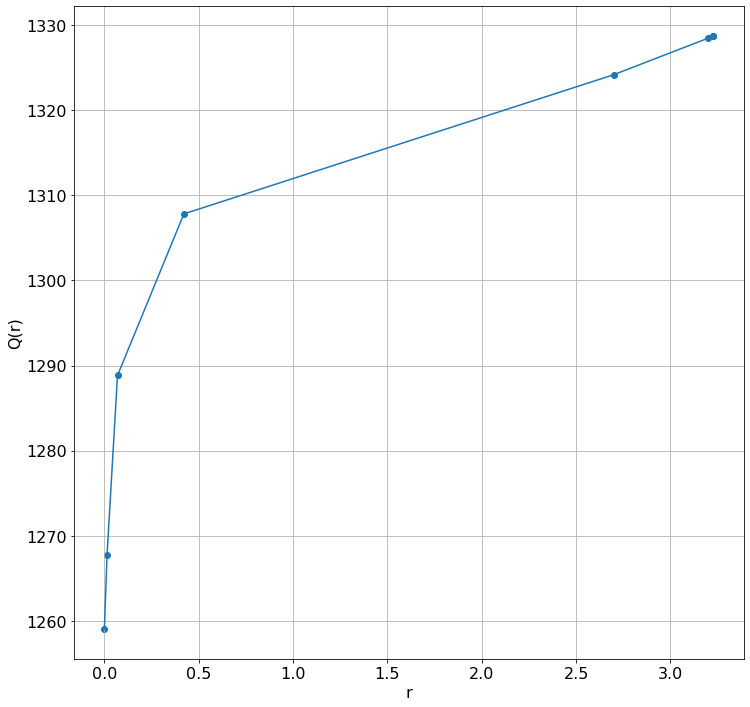

In [ ]:
b = lambda r : np.linalg.inv(X.T @ X + r * np.eye(m)) @ X.T @ y

s = lambda beta: np.sum((y - X @ beta) ** 2) / (n - m - 1)

dr = lambda r, beta, sigma : (r ** 2 * beta.T @ (np.linalg.inv(X.T @ X + r * np.eye(m)) @ 
                                  np.linalg.inv(X.T @ X + r * np.eye(m))) @ beta + sigma * 
                                  np.trace(X @ (np.linalg.inv(X.T @ X + r * np.eye(m)) @ 
                                  np.linalg.inv(X.T @ X + r * np.eye(m))) @ X.T))

Q = lambda beta: (y - X @ beta).T @ (y - X @ beta)

def ridge_regression(y, X, epsilon = 0.001):
  # параметр epsilon задает отклонение оптимальной оценки от найденной
  # когда разность между оценками станет меньше epsilon,
  # поиск оптимальной ридж-оценки завершится

  r, q = [0], []
  beta = [b(r[-1])]
  sigma = s(beta[-1])
  rnew = opt.minimize(dr, x0 = 0, args = (beta[-1], sigma)).x[0]
  q.append(Q(beta[-1]))
  while(abs(r[-1] - rnew) > epsilon):
    r.append(rnew)
    beta.append(b(r[-1]))
    sigma= s(beta[-1])
    rnew = opt.minimize(dr, x0 = r[-1], args = (beta[-1], sigma)).x[0]
    q.append(Q(beta[-1]))
  
  return np.array(r), np.array(q), np.array(beta)

r, q, beta = ridge_regression(y, X)

print('Сумма квадратов ошибок в случае МНК-оценки меньше, чем в случае оптимальной ридж-оценки в', q[0] / q[-1], 'раз')
print('График зависимости суммы квадратов ошибок отклонений от r')
fig = plt.figure(figsize=(12, 12))
plt.scatter(r, q)
plt.plot(r, q)
plt.xlabel('r')
plt.ylabel('Q(r)')
plt.grid()
plt.show()

- (b). Построим графики изменения координат ридж-оценки в зависимости от значения $r$ для каждой координаты вектра $\beta$ (то есть для $\beta_0, \ \beta_1, ..., \ \beta_m$).

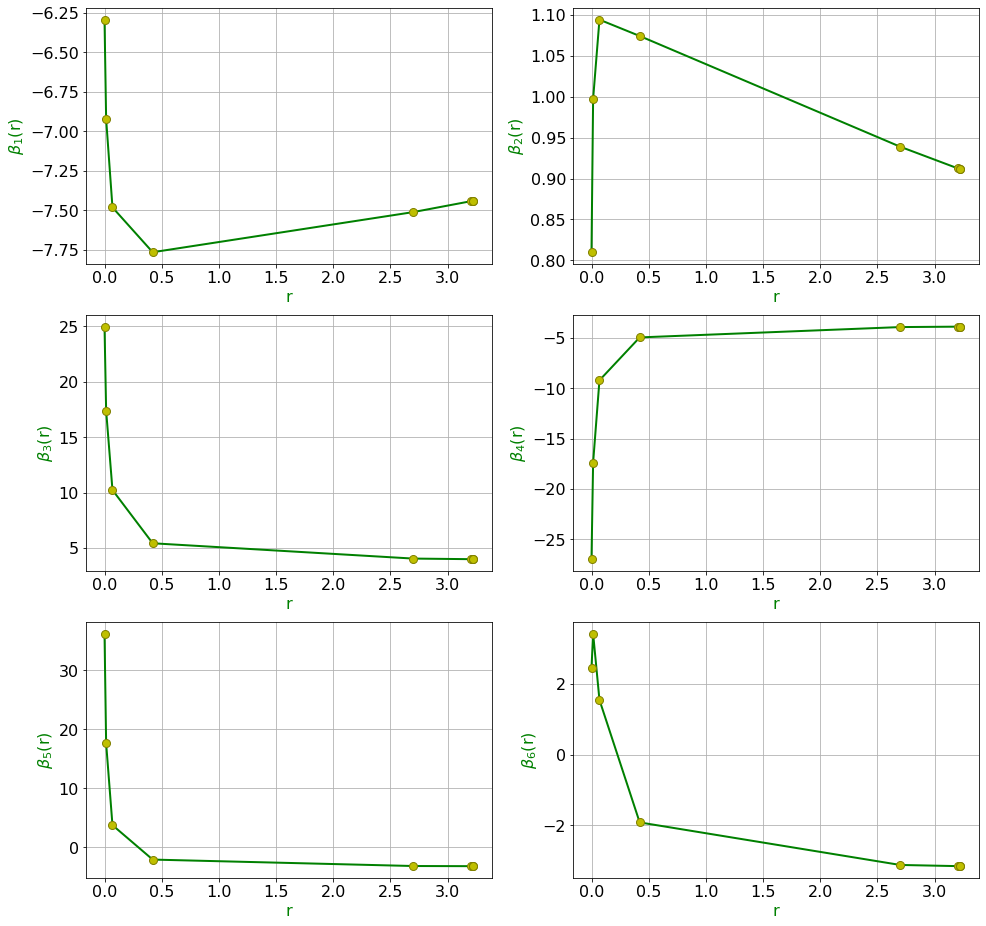

In [ ]:
fig = plt.figure(figsize=(16, 16))

for i in range(m):
    plt.subplot(3, 2, i + 1)
    plt.xlabel('r', color='green')
    plt.ylabel(rf'$\beta_{i + 1}$(r)', color='green')
    plt.rcParams.update({'font.size': 16}) 
    plt.grid()
    plt.plot(r, beta.T[i], color='green', linewidth = 2, marker = 'o', markersize = 8, markerfacecolor = 'y',
            markeredgecolor = 'olive', markeredgewidth = 1)

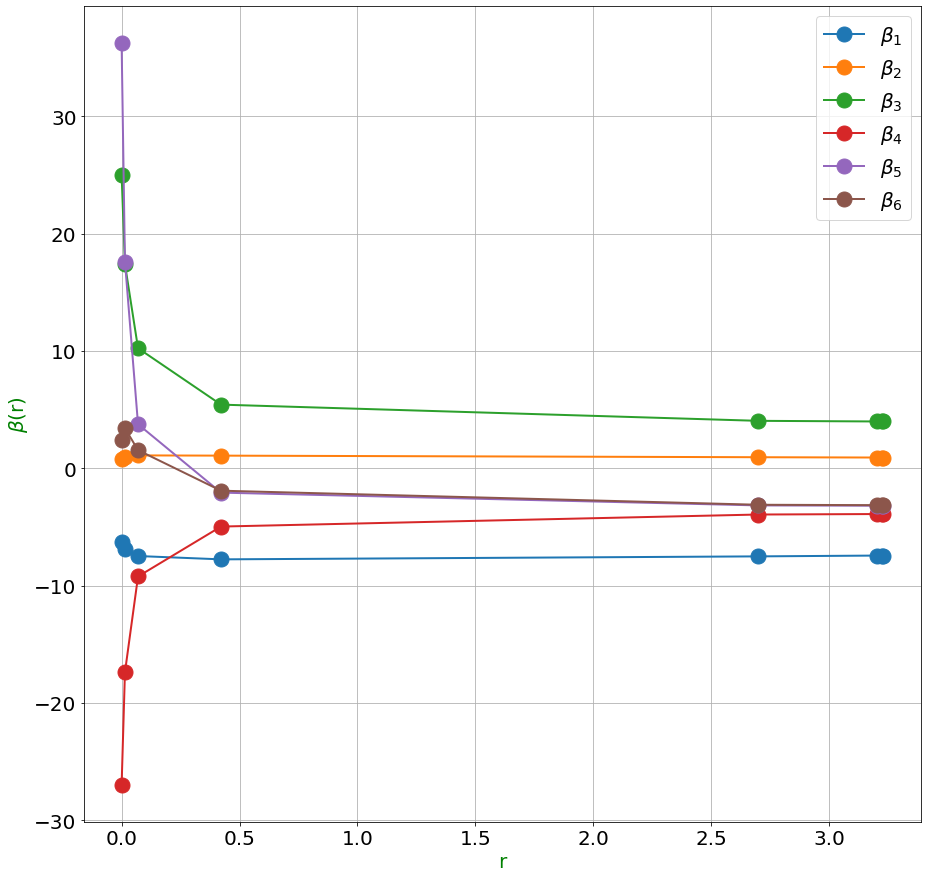

In [ ]:
fig = plt.figure(figsize=(15, 15))

for i in range(m):
    plt.xlabel('r', color='green')
    plt.ylabel(rf'$\beta$(r)', color='green')
    plt.rcParams.update({'font.size': 20}) 
    plt.grid(True)
    plt.rcParams.update({'font.size': 20})
    plt.plot(r, beta.T[i], linewidth = 2, marker = 'o', markersize = 15, markeredgewidth = 1, label = rf'$\beta_{i + 1}$')
    plt.legend()

- (c). Построим график изменения лассо-оценки в зависимости от параметра $r$.

Для этого необходимо сначала получить формулу для лассо-оценки параметра $\beta$ в зависимости от $r$.

Запишем функционал, который будем минимизировать $F(\beta) = (\mathbb{Y} - \mathbb{X}\beta)^T(\mathbb{Y} - \mathbb{X}\beta) + r \sum_\limits{j = 1}^m| \beta_j |$.

Производная $F(\beta)$ по $\beta$ равна $-\mathbb{X}^T(\mathbb{Y} - \mathbb{X}\beta) + sign({\beta})r$. Приравняв ее к нулю и выразив $\beta$, получим $\beta = (\mathbb{X}^T\mathbb{X})^{-1}(\mathbb{X}^T\mathbb{Y} - sign({\beta})r)$. Заменим $sign(\beta)$ на $sign(\tilde\beta)$. Тогда $\hat\beta = (\mathbb{X}^T\mathbb{X})^{-1}(\mathbb{X}^T\mathbb{Y} - sign(\tilde{\beta})r)$.

Далее запишем пошаговое обновление параметра $\beta$ в следующей форме: пусть $\rho_j = \sum\limits_{i=1}^n x_j^{(i)}  (y^{(i)}  - \sum\limits_{k \neq j}^m \beta^{}_k x_k^{(i)} ) = \sum\limits_{i=1}^n x_j^{(i)}  (y^{}  - \hat y^{(i)}+ \beta_j x_j^{(i)} )$ на $j$-ом шаге.

Определим функцию \begin{aligned}
     S^{(i)} = \begin{cases}
       \beta^{(i)}_j = \rho^{(i)}_j + r & , \ \rho^{(i)}_j < - r \\
       \beta^{(i)}_j = 0 & , \ - r \leq \rho^{(i)}_j \leq r \\
       \beta^{(i)}_j = \rho^{(i)}_j - r & , \ \rho^{(i)}_j > r 
    \end{cases}.
\end{aligned}

Функция $S$ итеративно вычисляет значение координаты вектора $\beta$. И на каждом шаге $\beta_j = (S^{(1)}, S^{(2)}, ... , S^{(m)})$.

In [ ]:
def S(rho, r):
    R = []
    for p in rho:
      if p < -r:
          R.append(p + r)
      elif p > r:
          R.append(p - r)
      else: 
          R.append(0)
    return np.array(R)
      

def lasso_regression(beta, y, X, r = .01, num = 100):
    m, n = X.shape
    X = X / (np.linalg.norm(X, axis = 0))
    for i in range(num): 
        for j in range(n):
            X_j = X[:,j].reshape(-1,1)
            rho = (y - (X @ beta).T  + (beta[j]*X_j).T) @ X_j  
            beta[j] =  S(rho, r)   
            
    return beta.flatten()

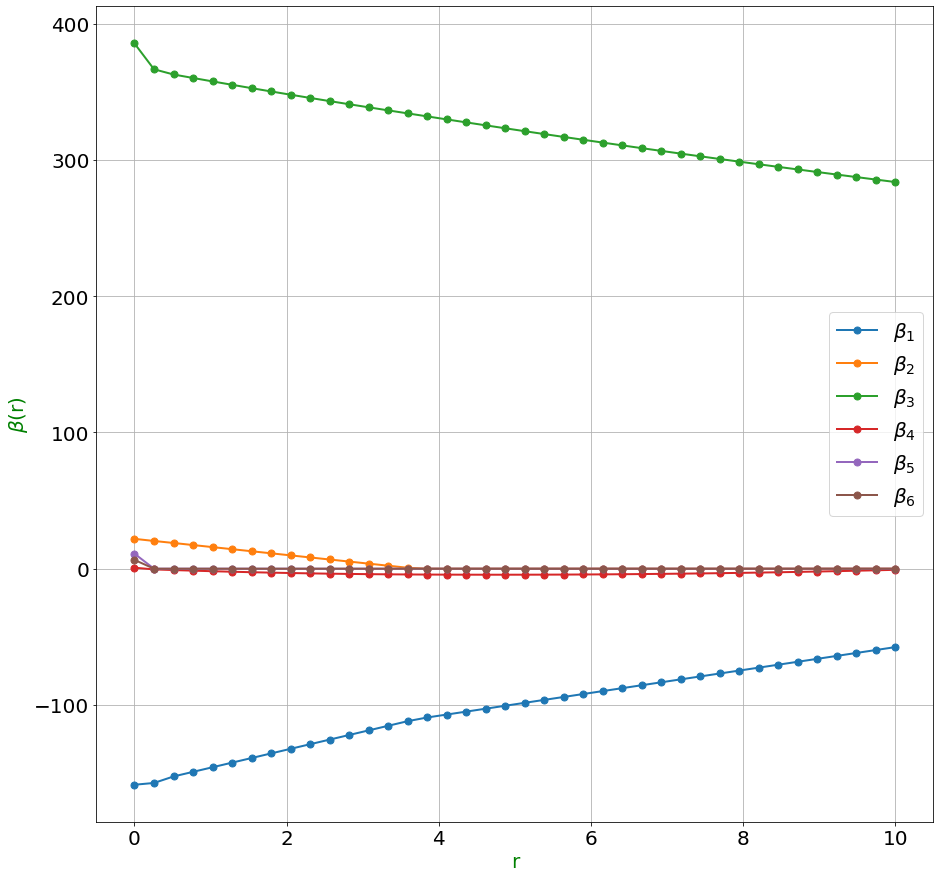

In [ ]:
init_beta = np.ones((m,1))
beta_list = []
r = np.linspace(0, 10, 40)

for k in r:
    beta = lasso_regression(init_beta, y, X, k, num = 40)
    beta_list.append(beta)

beta = np.stack(beta_list).T
m,_ = beta.shape


plt.figure(figsize = (15, 15))
for i in range(m):
    plt.plot(r, beta[i], linewidth = 2, marker = 'o', markersize = 7, markeredgewidth = 1, label = rf'$\beta_{i + 1}$')
plt.xlabel('r', color ='green')
plt.ylabel(rf'$\beta$(r)', color='green')
plt.legend()
plt.grid()

## Задача 4.

Сгенерируем выборку.

In [ ]:
X = np.array([sts.norm.rvs(loc=0, scale=1, size=100), sts.laplace.rvs(loc=0, scale=1, size=100)])
y = np.array([sts.uniform.rvs(loc=0, scale=exp(-x), size=1) for x in X[0]])

Проекции на оси.

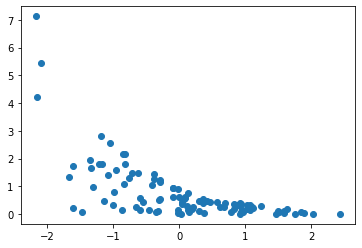

In [ ]:
plt.scatter(X[0], y)

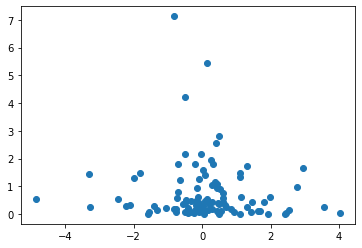

In [ ]:
plt.scatter(X[1], y)

Оценкку для модели найдем методом наименьших квадратов.

In [ ]:
K = X @ X.T
m = np.size(K[0])
beta = np.linalg.inv(K) @ X @ y
print('Оценка параметра бета равна:\n', beta)
print('Модифицированный критерий детерминации равен:')
print((1 - (len(y) - 1) * np.sum((y - X.T @ beta)**2) / (len(y) - m) / np.sum((y - np.mean(y))**2)))

Оценка параметра бета равна:
 [[-0.66980797]
 [ 0.02106853]]
Модифицированный критерий детерминации равен:
-0.116842026318428


Таким образом, выборка удовлетворяет условию $R_{adj}^2$ < 0.

## Задача 5.

Реализуем функцию `stepwise`, которая находит лучший набор регрессоров.

In [ ]:
# функция для вычисления меры адекватности модели
def RsqAdj(y, X):
    K = X.T @ X
    m = np.size(K[0])
    beta = np.linalg.inv(K) @ X.T @ y
    return (1 - (len(y) - 1) * np.sum((y - X @ beta)**2) / (len(y) - m) / np.sum((y - np.mean(y))**2))

# вспомогательная функция для нахождения всех подмножеств
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))


def stepwise(y, X, mes, method = 'iter_subsets', epsilon = 0.001):
    # данная функция, помимо у и Х, принимает на вход следующие параметры:
    # mes -- функция, которая осуществляет вычисление меры адекватности модели
    # method -- способ пошаговой регрессии
    # epsilon -- отклонение между мерами адекватности модели.
    # если отклонение между мерами меньше epsilon, отбор прекращается
    
    # в списке Sset будут храниться подмножества с индексами регрессоров
    Sset = list(powerset([i for i in range(1, len(X.T) + 1)]))
    
    # для регрессии всех подмножеств
    if method == 'iter_subsets':
        # в списке Т будут храниться значения меры адекватности модели
        T = []
        
        # организуем цикл, в котором будем перебирать все подмножества регрессоров
        for subset in Sset:
            x = np.array([X.T[i - 1] for i in subset])
            T.append(mes(y, x.T))
            
        T = np.array(T)
        # находим подномножество регрессоров, которому соответствует максимальная мера адекватности
        s = Sset[np.argmax(T)]
        
        return s, np.max(T)
    
    # для прямого отбора
    if method == 'forward':
        # инициализируем подмножество регрессоров пустым списком
        s = []
        # начальная мера адекватности модели
        Told = mes(y, np.array([X.T[0]]).T)
        
        # организуем цикл, в котором будем перебирать все подмножества регрессоров
        for index, subset in enumerate(Sset):
            x = np.array([X.T[i - 1] for i in subset])
            Tnew = mes(y, x.T)
            
            # пока T растет и разность между старым и новым значением меньше epsilon
            if abs(Tnew - Told) < epsilon:
                if Tnew > Told:
                    s = subset
                    break
                elif Tnew < Told and Tnew > 0:
                    Tnew = Told
                    s = Sset[index - 1]
                    break
            elif abs(Tnew - Told) > epsilon and Tnew > Told:
                Told = Tnew
                
        return s, Tnew
        
    # для обратного отбора
    if method == 'backward':
        # начальная мера адекватности модели
        Told = mes(y, np.array(X))
        # инициализируем подмножество регрессоров всеми регрессорами
        s = list(Sset[-1])
        Sset.reverse()
        
        # организуем цикл, в котором будем перебирать все подмножества регрессоров,
        # начиная со всего множества и постепенно выбрасывая регрессоры
        for index, subset in enumerate(Sset):
            x = np.array([X.T[i - 1] for i in subset])
            Tnew = mes(y, x.T)
            
            # пока T растет и разность между старым и новым значением меньше epsilon
            if abs(Tnew - Told) < epsilon:
                if Tnew > Told:
                    s = subset
                    break
                elif Tnew < Told and Tnew > 0:
                    Tnew = Told
                    s = Sset[index - 1]
                    break
            elif abs(Tnew - Told) > epsilon and Tnew > Told:
                Told = Tnew 
                
        return s, Tnew  
    

# функция, осуществляющая перекрестную проверку 
# и возвращающая модифицированный коэффициент детерминации для тестовой выборки
def cross_valid(X_train, X_test, y_train, y_test, method = 'iter_subsets'):
    subset, T_train = stepwise(y_train, X_train, RsqAdj, method)
    X_set = np.array([X_train.T[i - 1] for i in subset]).T
    K = X_set.T @ X_set
    m = np.size(K[0])
    beta = np.linalg.inv(K) @ X_set.T @ np.array(y_train)
    X_test = np.array([X_test.T[i - 1] for i in subset])
    
    return (1 - (len(y_test) - 1) * np.sum((y_test - beta @ X_test)**2) / 
            (len(y_test) - m) / np.sum((y_test - np.mean(y_test))**2))


# функция, осуществляющая разделение выборки на тестовую и тренировочную
def train_test_split(X, y, ratio):
    # возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    X_train, X_test, y_train, y_test = tr(X, y, train_size = ratio, random_state = 60, shuffle = False)
    
    return [X_train, X_test, y_train, y_test]

In [ ]:
y = df['Ex5y'].to_numpy()
X = df.loc[:, 'Ex5x1':'Ex5x10'].to_numpy()

Применим данную функцию к выборке для трех указанных способов отбора.

In [ ]:
subset1, T1 = stepwise(y, X, RsqAdj, method = 'iter_subsets')
print('Для регрессии всех подмножеств модифицированный коэффициент детерминации равен:', T1)
print('Наилучшим набором регрессоров являеются регрессоры с номерами', subset1)

subset2, T2 = stepwise(y, X, RsqAdj, method = 'forward')
print('Для прямого отбора модифицированный коэффициент детерминации равен:', T2)
print('Наилучшим набором регрессоров являеются регрессоры с номерами', subset2)

subset3, T3 = stepwise(y, X, RsqAdj, method = 'backward')
print('Для обратного отбора модифицированный коэффициент детерминации равен:', T3)
print('Наилучшим набором регрессоров являеются регрессоры с номерами', subset3)

Для регрессии всех подмножеств модифицированный коэффициент детерминации равен: 0.8976778651457076
Наилучшим набором регрессоров являеются регрессоры с номерами (1, 2, 3, 5, 6, 7, 8)
Для прямого отбора модифицированный коэффициент детерминации равен: 0.8919521214678119
Наилучшим набором регрессоров являеются регрессоры с номерами (1, 3, 5, 6, 10)
Для обратного отбора модифицированный коэффициент детерминации равен: 0.8942291305582343
Наилучшим набором регрессоров являеются регрессоры с номерами (2, 3, 4, 5, 6, 7, 8, 9, 10)


Применим перекрестную проверку. Для этого разделим выборку на обучающую и тестовую в соотношении 7 : 3.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, ratio = 0.7)

Теперь посчитаем для каждого из способов шаговой регрессии модифицированный коэффициент детерминации.

Для регрессии всех подмножеств:

In [ ]:
cross_valid(X_train, X_test, y_train, y_test, method = 'iter_subsets')

0.9044714272164569

Для прямого отбора:

In [ ]:
cross_valid(X_train, X_test, y_train, y_test, method = 'forward')

0.8970044395860252

Для обратного отбора:

In [ ]:
cross_valid(X_train, X_test, y_train, y_test, method = 'backward')

0.849548063847969